In [1]:
import numpy as np
import pandas as pd
from skew_autotransform import skew_autotransform
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


weather_df.head(10)

date        summary preciptype  temperature  \
0 2006-03-31 22:00:00+00:00  Partly Cloudy       rain     9.472222   
1 2006-03-31 23:00:00+00:00  Partly Cloudy       rain     9.355556   
2 2006-04-01 00:00:00+00:00  Mostly Cloudy       rain     9.377778   
3 2006-04-01 01:00:00+00:00  Partly Cloudy       rain     8.288889   
4 2006-04-01 02:00:00+00:00  Mostly Cloudy       rain     8.755556   
5 2006-04-01 03:00:00+00:00  Partly Cloudy       rain     9.222222   
6 2006-04-01 04:00:00+00:00  Partly Cloudy       rain     7.733333   
7 2006-04-01 05:00:00+00:00  Partly Cloudy       rain     8.772222   
8 2006-04-01 06:00:00+00:00  Partly Cloudy       rain    10.822222   
9 2006-04-01 07:00:00+00:00  Partly Cloudy       rain    13.772222   

   apparenttemperature  humidity  windspeed  windbearing  visibility  \
0             7.388889      0.89    14.1197        251.0     15.8263   
1             7.227778      0.86    14.2646        259.0     15.8263   
2             9.377778      0.89     3.9284        204.0     14.9569   
3             5.944444      0.83    14.1036        269.0     15.8263   
4             6.977778      0.83    11.0446        259.0     15.8263   
5             7.111111      0.85    13.9587        258.0     14.9569   
6             5.522222      0.95    12.3648        259.0      9.9820   
7             6.527778      0.89    14.1519        260.0      9.9820   
8            10.822222      0.82    11.3183        259.0      9.9820   
9            13.772222      0.72    12.5258        279.0      9.9820   

   loudcover  pressure                       dailysummary  
0        0.0   1015.13  Partly cloudy throughout the day.  
1        0.0   1015.63  Partly cloudy throughout the day.  
2        0.0   1015.94  Partly cloudy throughout the day.  
3        0.0   1016.41  Partly cloudy throughout the day.  
4        0.0   1016.51  Partly cloudy throughout the day.  
5        0.0   1016.66  Partly cloudy throughout the day.  
6        0.0   1016.72  Partly cloudy throughout the day.  
7        0.0   1016.84  Partly cloudy throughout the day.  
8        0.0   1017.37  Partly cloudy throughout the day.  
9        0.0   1017.22  Partly cloudy throughout the day.


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'temperature' . Skewness = 0.09


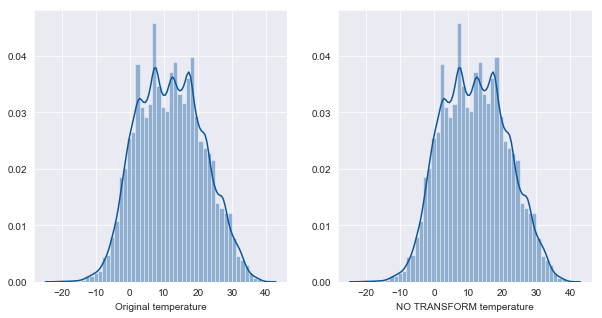


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'apparenttemperature' . Skewness = -0.06


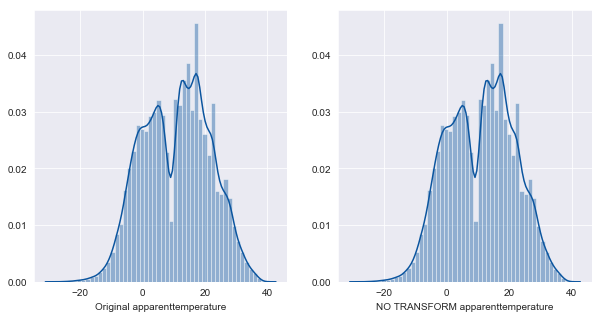


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'humidity' . Skewness = -0.72


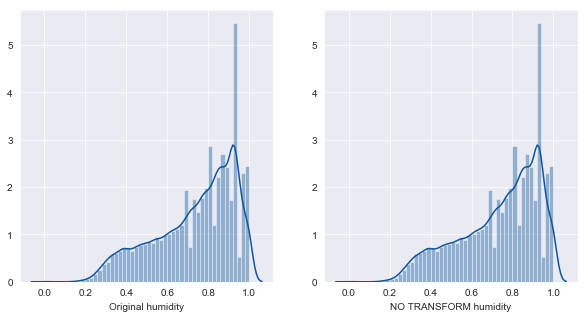


 ------------------------------------------------------

 'windspeed' had 'positive' skewness of 1.11

 Transformation yielded skewness of -0.00


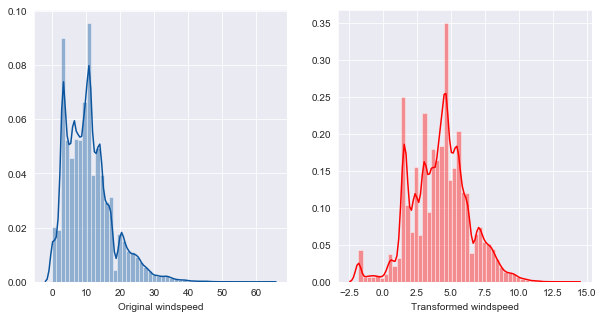


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'windbearing' . Skewness = -0.15


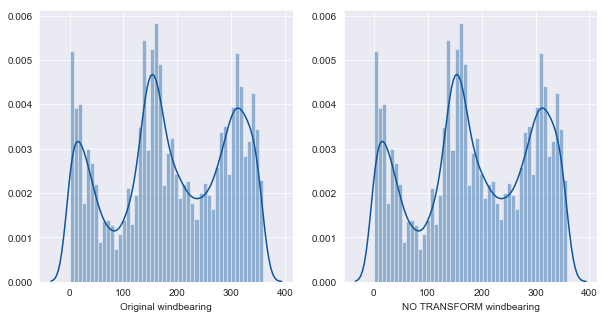


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'visibility' . Skewness = -0.50


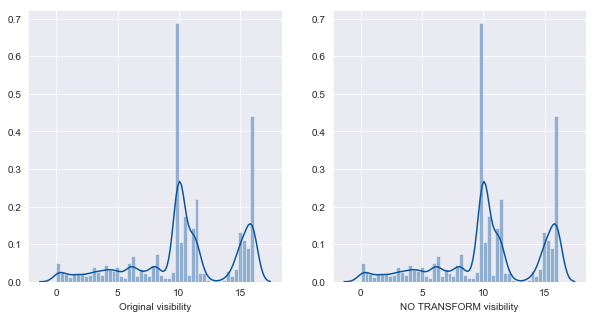


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'loudcover' . Skewness = 0.00


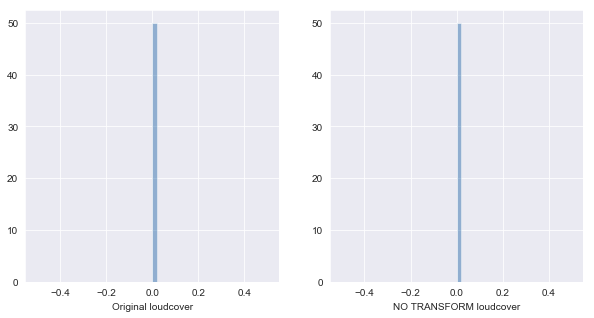


 ------------------------------------------------------

 'pressure' had 'negative' skewness of -8.42

 Transformation yielded skewness of -6.90


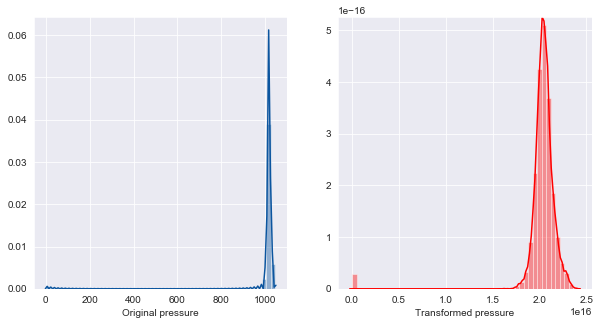

In [3]:
# check for skewness and normality
weather_df2 = skew_autotransform.skew_autotransform(weather_df.copy(deep=True), plot = True, exclude=('date','summary','preciptype', 'dailysummary'))


In [25]:
# Feature engineering for model
weather_df3 = weather_df2.loc[:, ('humidity', 'windspeed')]
weather_df3['humidity_windspeed'] = weather_df3['humidity'] * weather_df3['windspeed']
weather_df3['apparentdifference'] =  weather_df2['apparenttemperature'] - weather_df2['temperature']

corr = weather_df3.corr()
corr.style.background_gradient(cmap='RdBu_r')

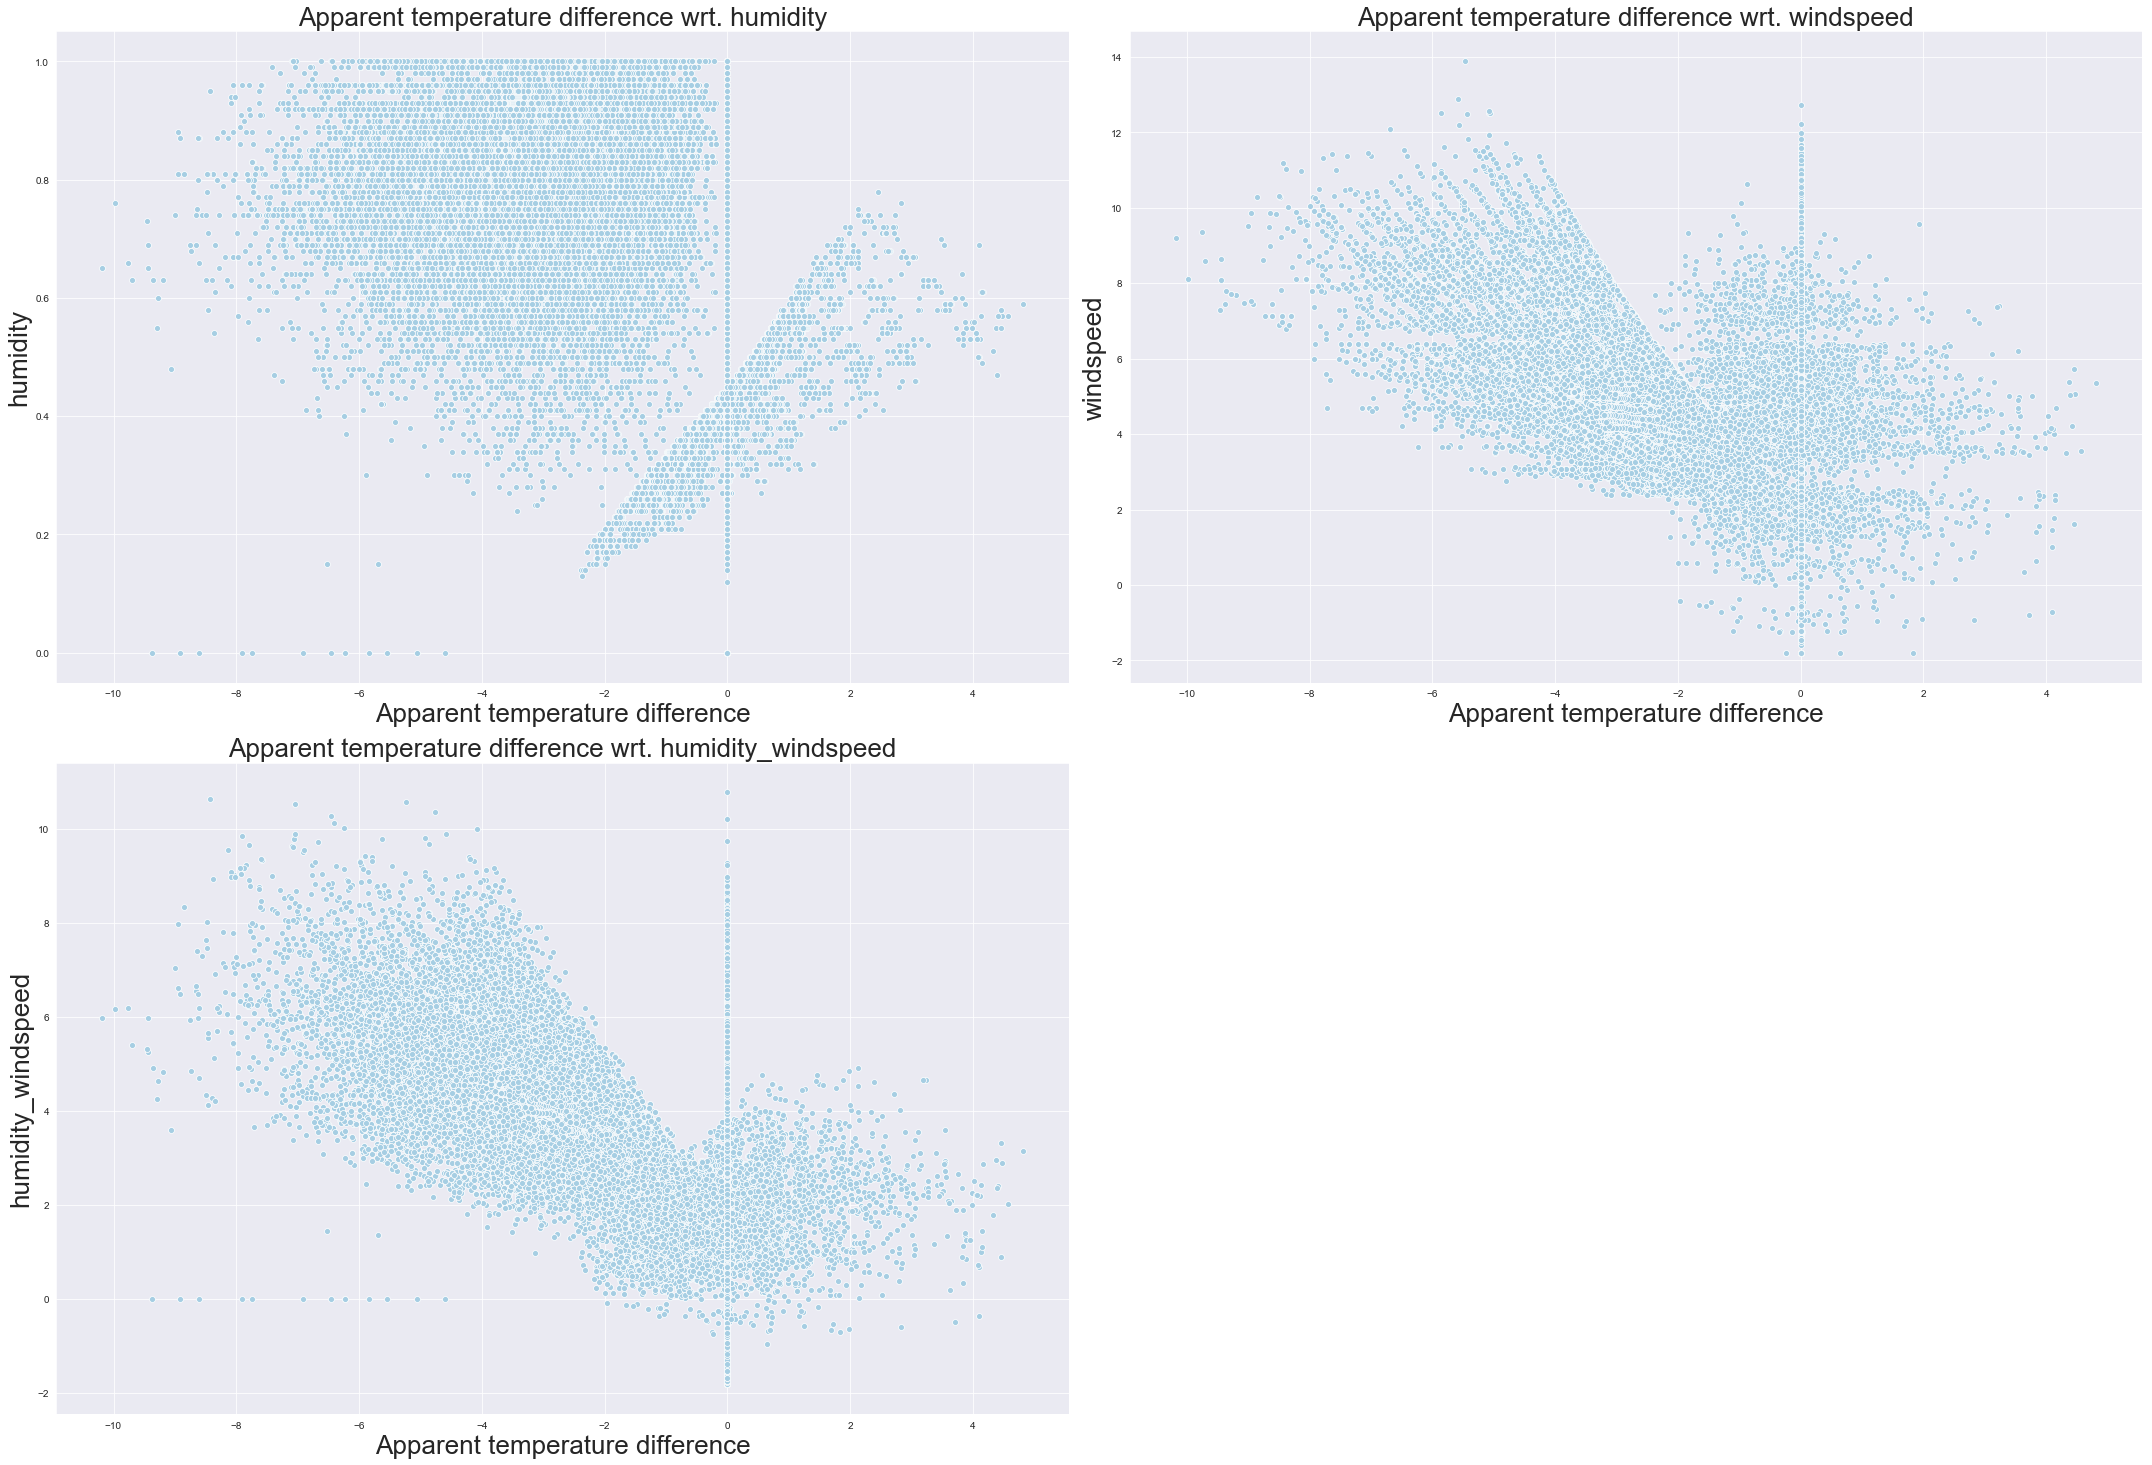

In [20]:
# visualize differences in temperature accross the different explanatory variables
plt.figure(figsize=(30,30))

cols = weather_df3.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(3,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df3)
    plt.title('Apparent temperature difference wrt. {}'.format(column), size=26)
    plt.xlabel('Apparent temperature difference', size=26)
    plt.ylabel(column, size=26)

plt.tight_layout()

plt.show()

## SciKit Learn model

In [26]:
target = weather_df3['apparentdifference']
data = weather_df3[cols]

# Initialize linear regression model
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 0.46641518  0.21585178 -0.82697855]

Intercept: 
 0.14643626281880118


Estimated model:

$$ Apparent temperature difference = 0.15 +0.47*Humidity +0.22*Windspeed -0.83*Humidity*Windspeed\qquad$$

## StatsModels model

In [27]:
sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     apparentdifference   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                 1.610e+04
Date:                Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                        13:43:15   Log-Likelihood:            -1.6725e+05
No. Observations:               96453   AIC:                         3.345e+05
Df Residuals:                   96449   BIC:                         3.345e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1464      0.041      3.533      0.000       0.065       0.228
humidity               0.4664      0.052      8.921      0.000       0.364       0.569
windspeed              0.2159      0.008     25.930      0.000       0.200       0.232
humidity_windspeed    -0.8270      0.011    -75.462      0.000      -0.848      -0.805
==============================================================================
Omnibus:                     5072.882   Durbin-Watson:                   0.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7416.335
Skew:                          -0.476   Prob(JB):                         0.00
Kurtosis:                       3.970   Cond. No.                         89.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model improvement
## Split model into two based on bimodal apparent temperature distribution

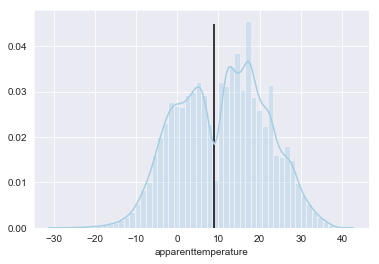

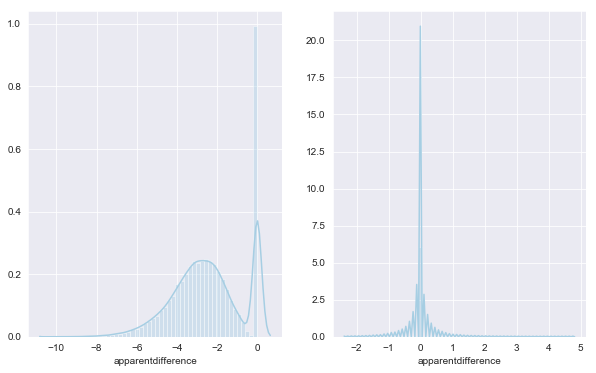

In [56]:
# apparent temp distribution
sns.distplot(weather_df2['apparenttemperature'])
plt.vlines(x=9, ymin=0, ymax=0.045)
plt.show()

weather_df_cold = weather_df3[weather_df2['apparenttemperature'] < 9]
weather_df_warm = weather_df3[weather_df2['apparenttemperature'] >= 9]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(weather_df_cold['apparentdifference'])
plt.subplot(1,2,2)
sns.distplot(weather_df_warm['apparentdifference'])
plt.show()

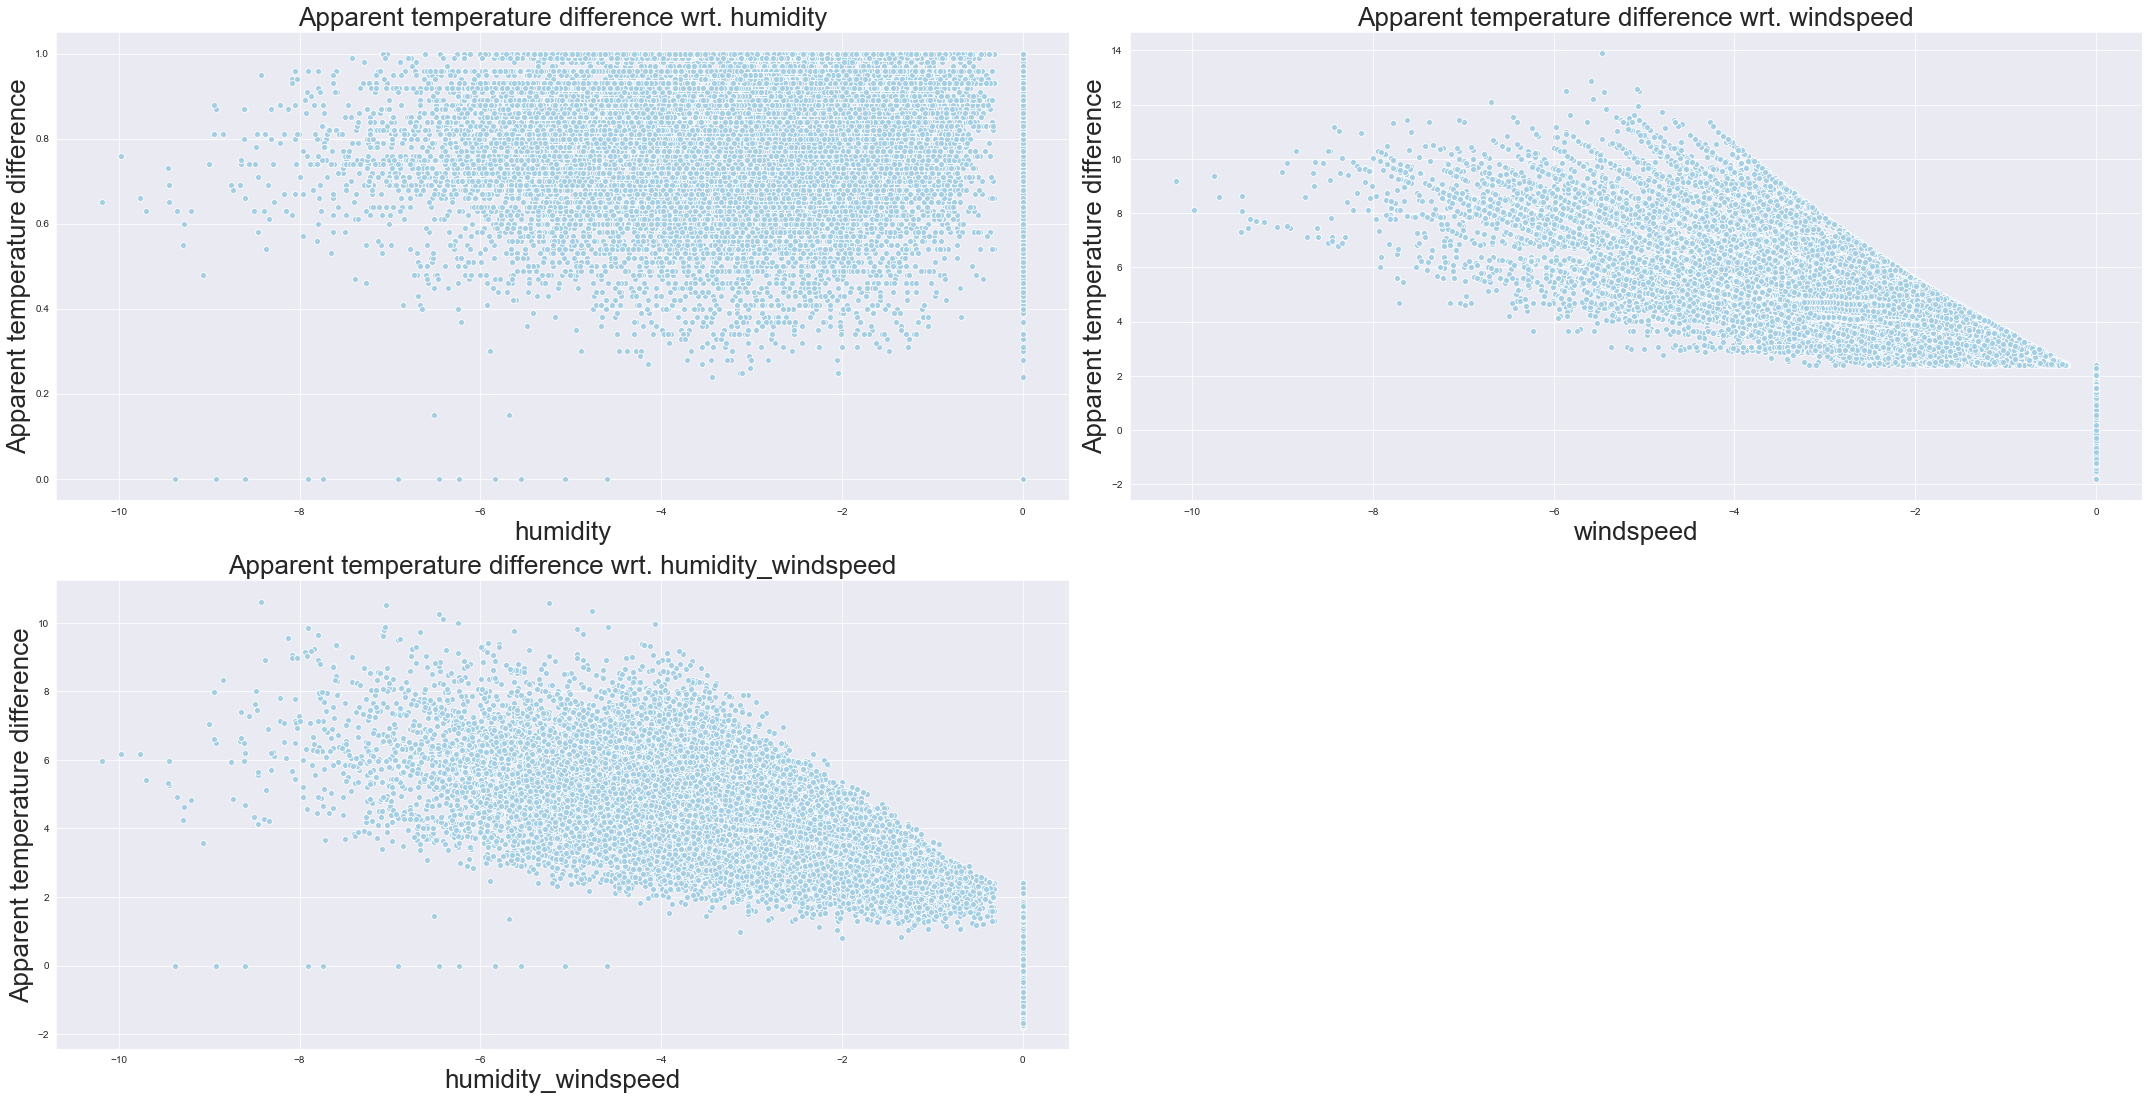

In [57]:
# visualize differences in apparent cold temps
plt.figure(figsize=(30,30))

cols = weather_df_cold.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df_cold)
    plt.title('Apparent temperature difference wrt. {}'.format(column), size=26)
    plt.ylabel('Apparent temperature difference', size=26)
    plt.xlabel(column, size=26)

plt.tight_layout()
plt.show()

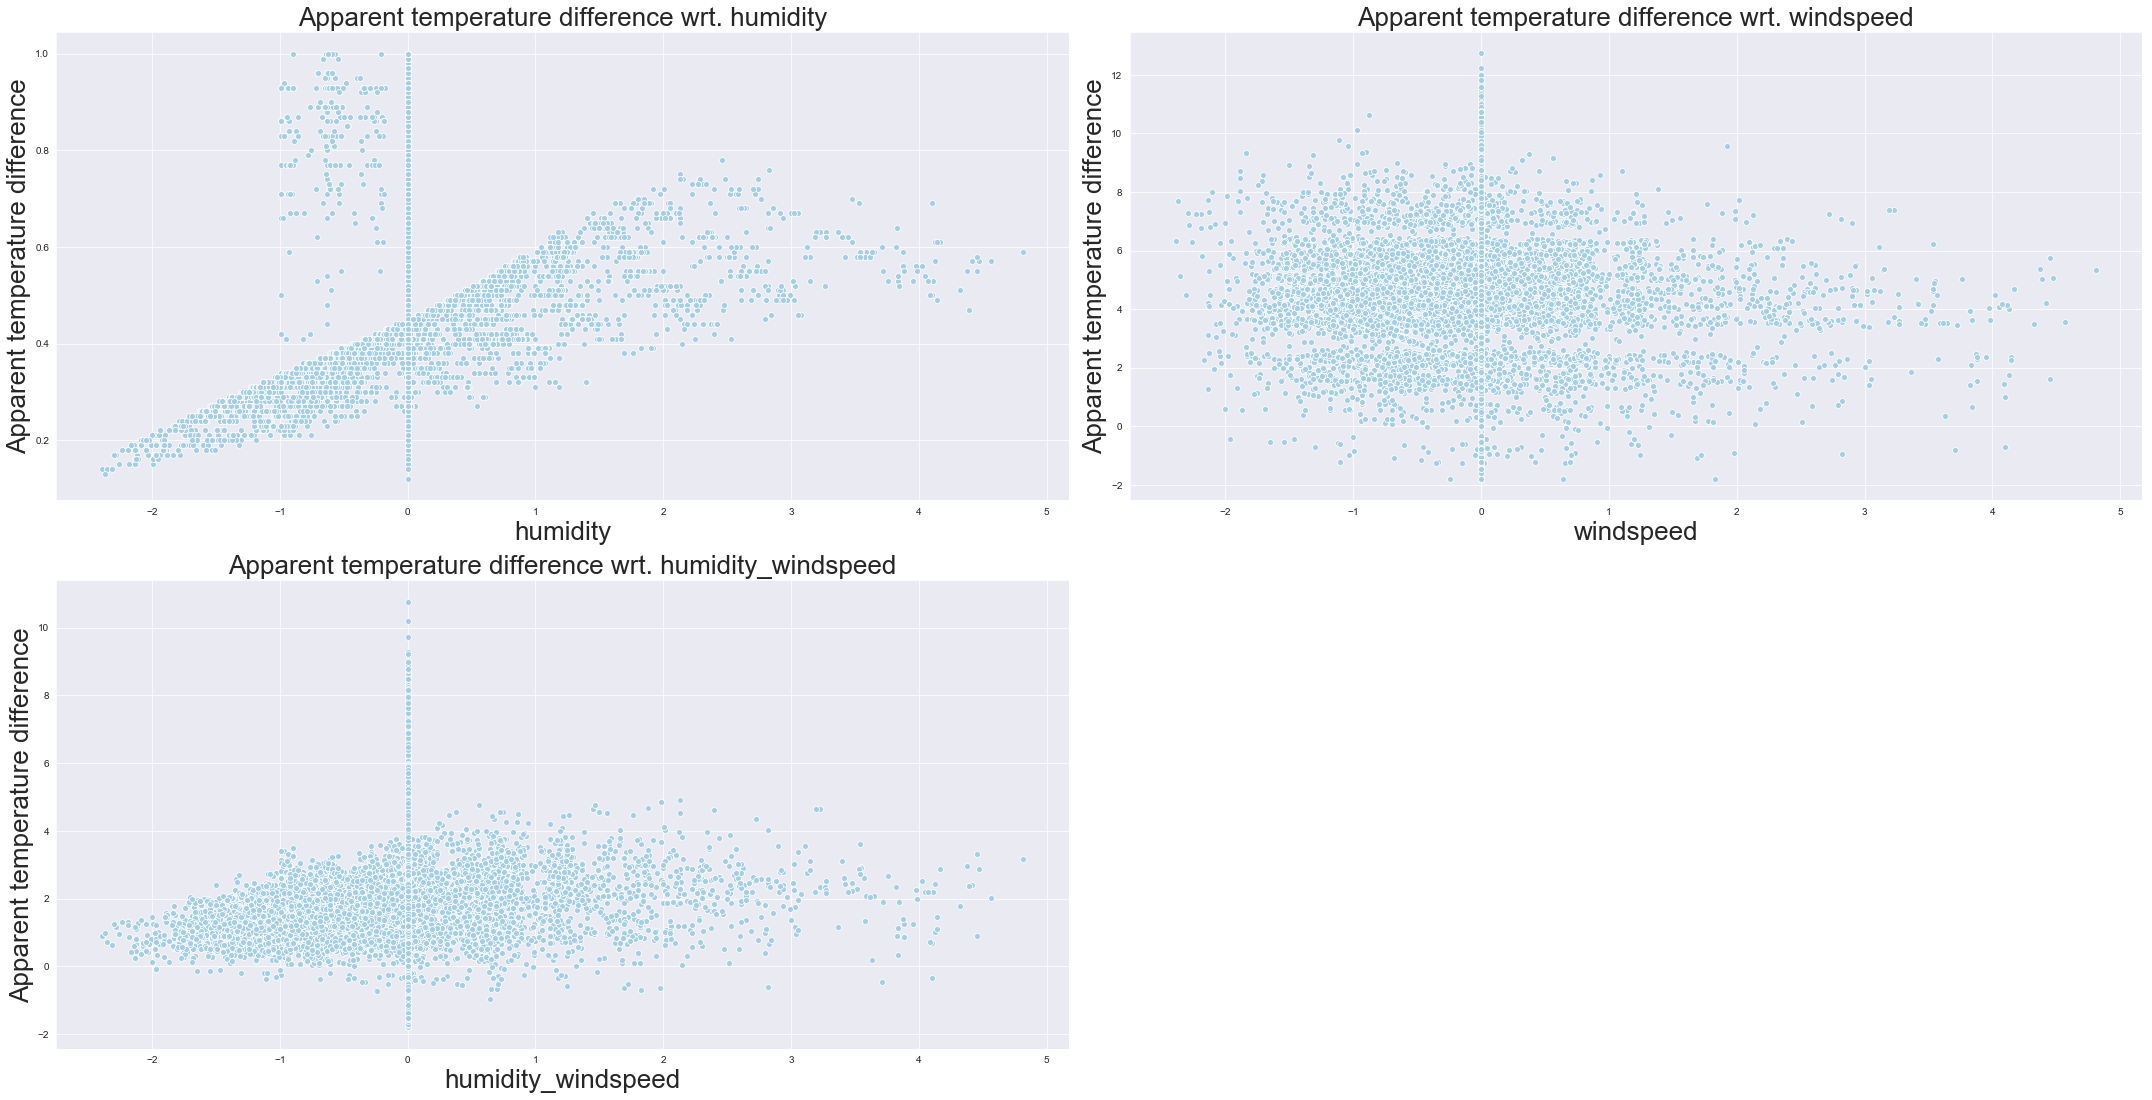

In [58]:
# visualize differences in apparent cold temps
plt.figure(figsize=(30,30))

cols = weather_df_warm.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df_warm)
    plt.title('Apparent temperature difference wrt. {}'.format(column), size=26)
    plt.ylabel('Apparent temperature difference', size=26)
    plt.xlabel(column, size=26)

plt.tight_layout()
plt.show()

## Assumptions check:

### 1. linearity of the model in its coefficients

### 2. the error term should be zero on average

In [8]:
predictions = lrm.predict(data)
errors = target - predictions
print("Mean of the errors in model is: {:.2}".format(np.mean(errors)))

Mean of the errors in model is: 9.1e-16


The average of the model's error is effectively zero.

### 3. homoscedasticity

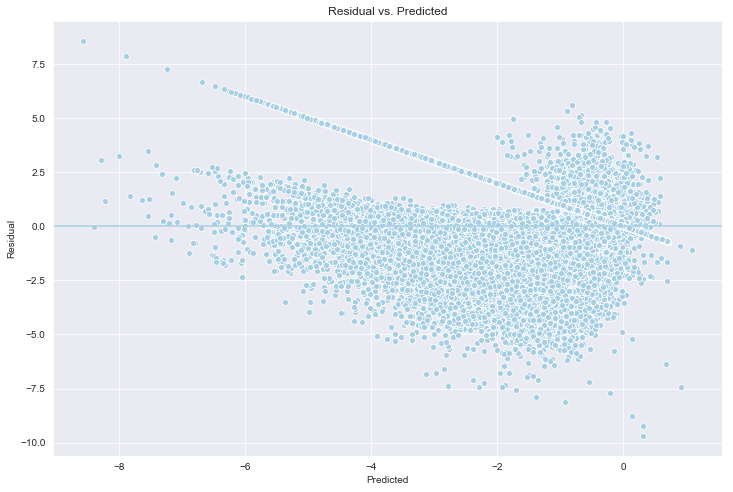

In [9]:
# visualizing homoscedasticity
plt.figure(figsize=(12,8))
sns.scatterplot(x=predictions, y=errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [10]:
# statistical tests for homoscedasticity
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 8522.53 and p value is 0
Levene test statistic value is 3623.23 and p value is 0


The p-values of both tests are lower than 0.05. The test results reject the null hypothesis which means our errors are heteroscedastic.

### 4. low multicollinearity

In [11]:
corr = weather_df3.corr()
corr.style.background_gradient(cmap='RdBu_r')

Low correlation between explanatory features

### 5. error terms should be uncorrelated with one another

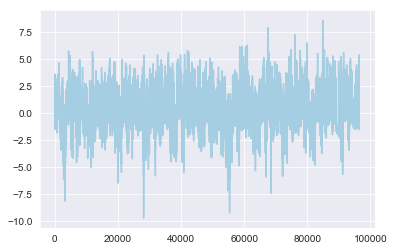

In [12]:
plt.plot(errors)
plt.show()

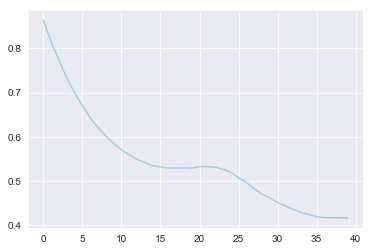

In [13]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### 6. features shouldn't be correlated with the errors

## Are the estimated coefficients statistically significant?

both coefficients are statistically significant according to the model's summary.

## Are the signs of the estimated coefficients in line with your previous expectations? 
Yes, both humidity and wind speed decrease the apparent temperature difference.

In [18]:
# Feature engineering for split model
weather_df2_cold = weather_df_cold.loc[:,('humidity', 'windspeed')]
weather_df2_cold['windspeed_inv'] = (weather_df2_cold['windspeed']) ** -1
weather_df2_cold['humidity_windspeed'] = weather_df2_cold['humidity'] * weather_df2_cold['windspeed']
weather_df2_cold['apparentdifference'] =  weather_df_cold['apparenttemperature'] - weather_df_cold['temperature']

weather_df2_warm = weather_df_warm.loc[:,('humidity', 'windspeed')]
weather_df2_warm['windspeed_inv'] = weather_df2_warm['windspeed'] ** -1
weather_df2_warm['apparentdifference'] =  weather_df_warm['apparenttemperature'] - weather_df_warm['temperature']



corr = weather_df2_cold.corr()
corr.style.background_gradient(cmap='RdBu_r')

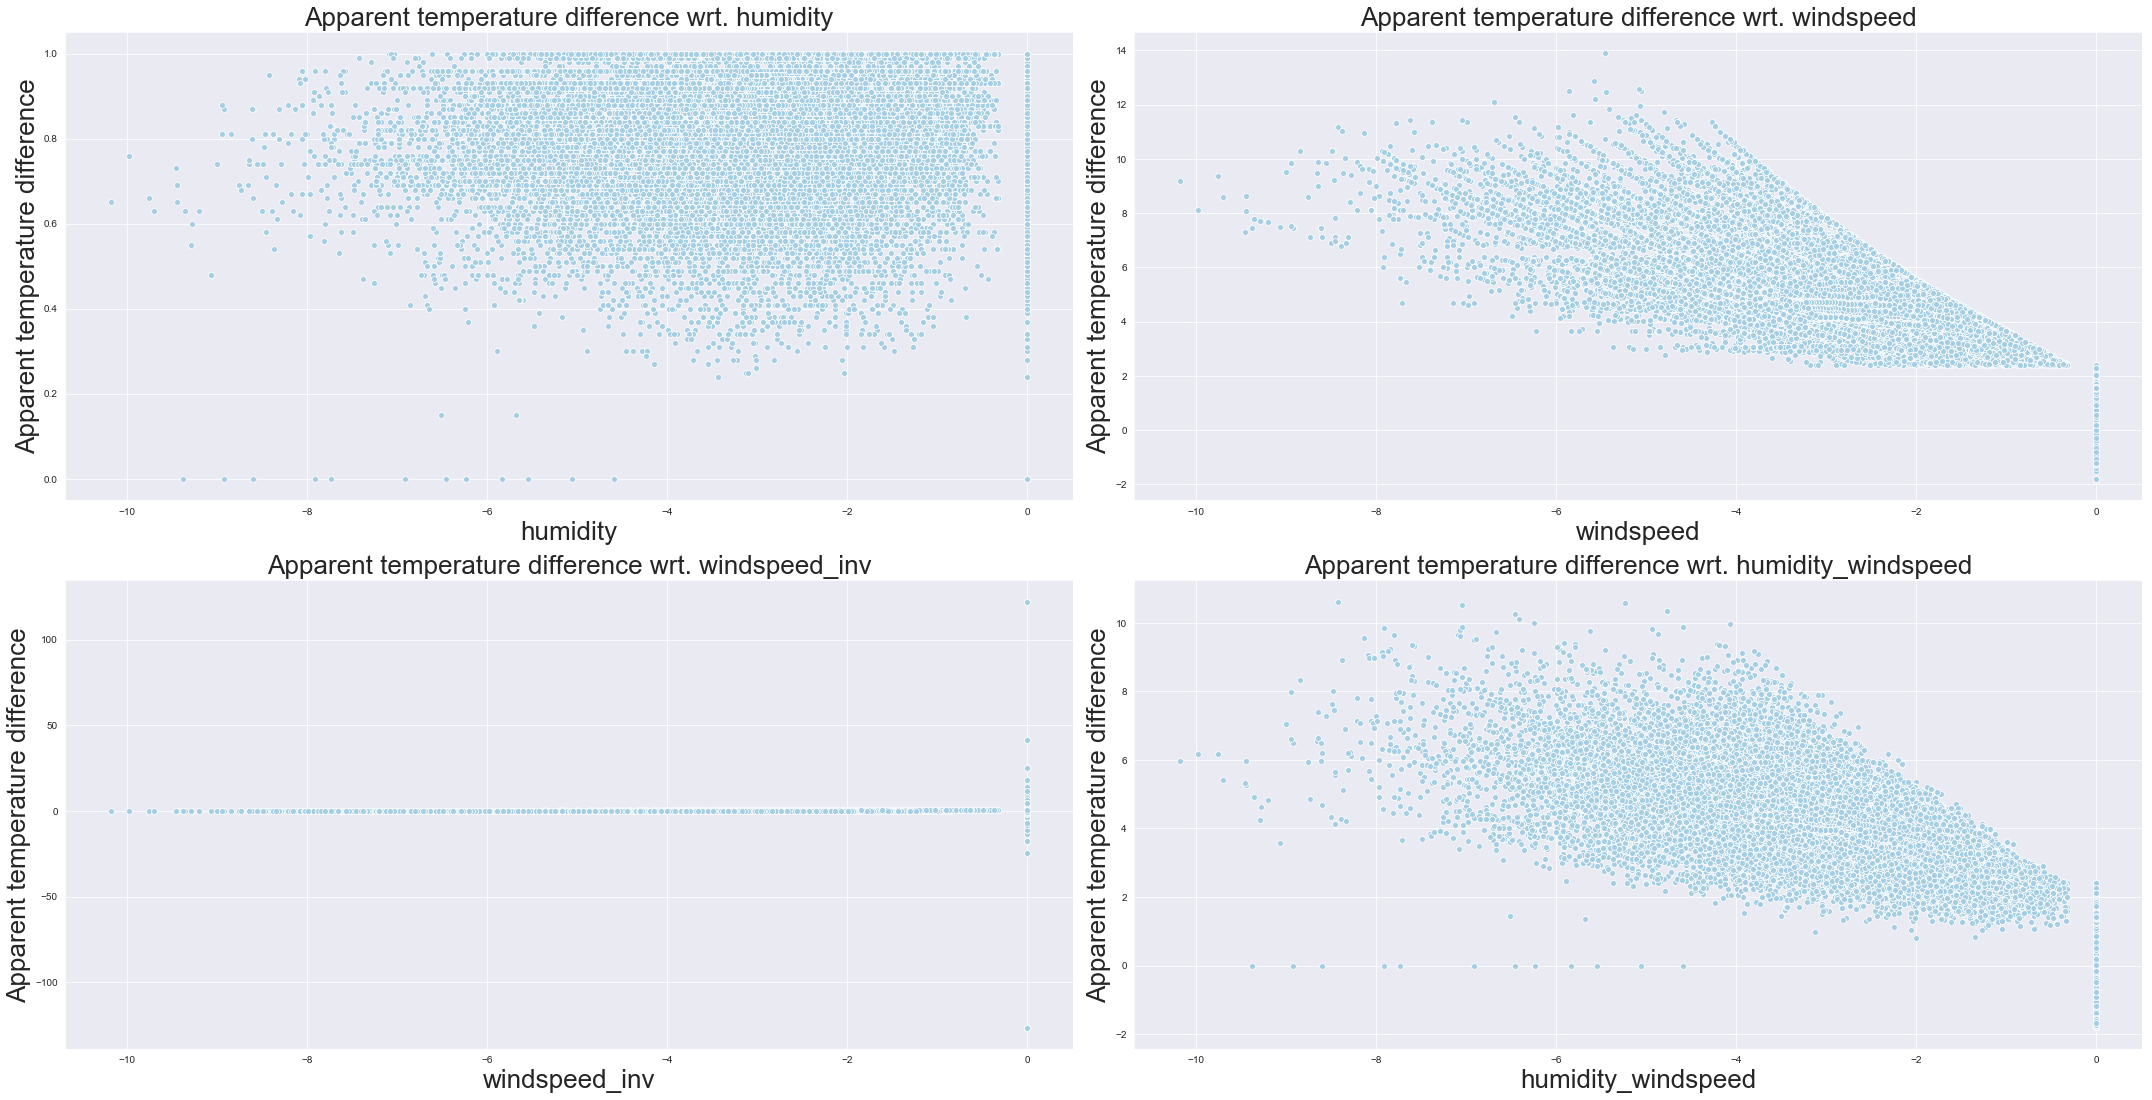

In [19]:
# visualize differences in apparent cold temps
plt.figure(figsize=(30,30))

cols = weather_df2_cold.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df2_cold)
    plt.title('Apparent temperature difference wrt. {}'.format(column), size=26)
    plt.ylabel('Apparent temperature difference', size=26)
    plt.xlabel(column, size=26)

plt.tight_layout()
plt.show()

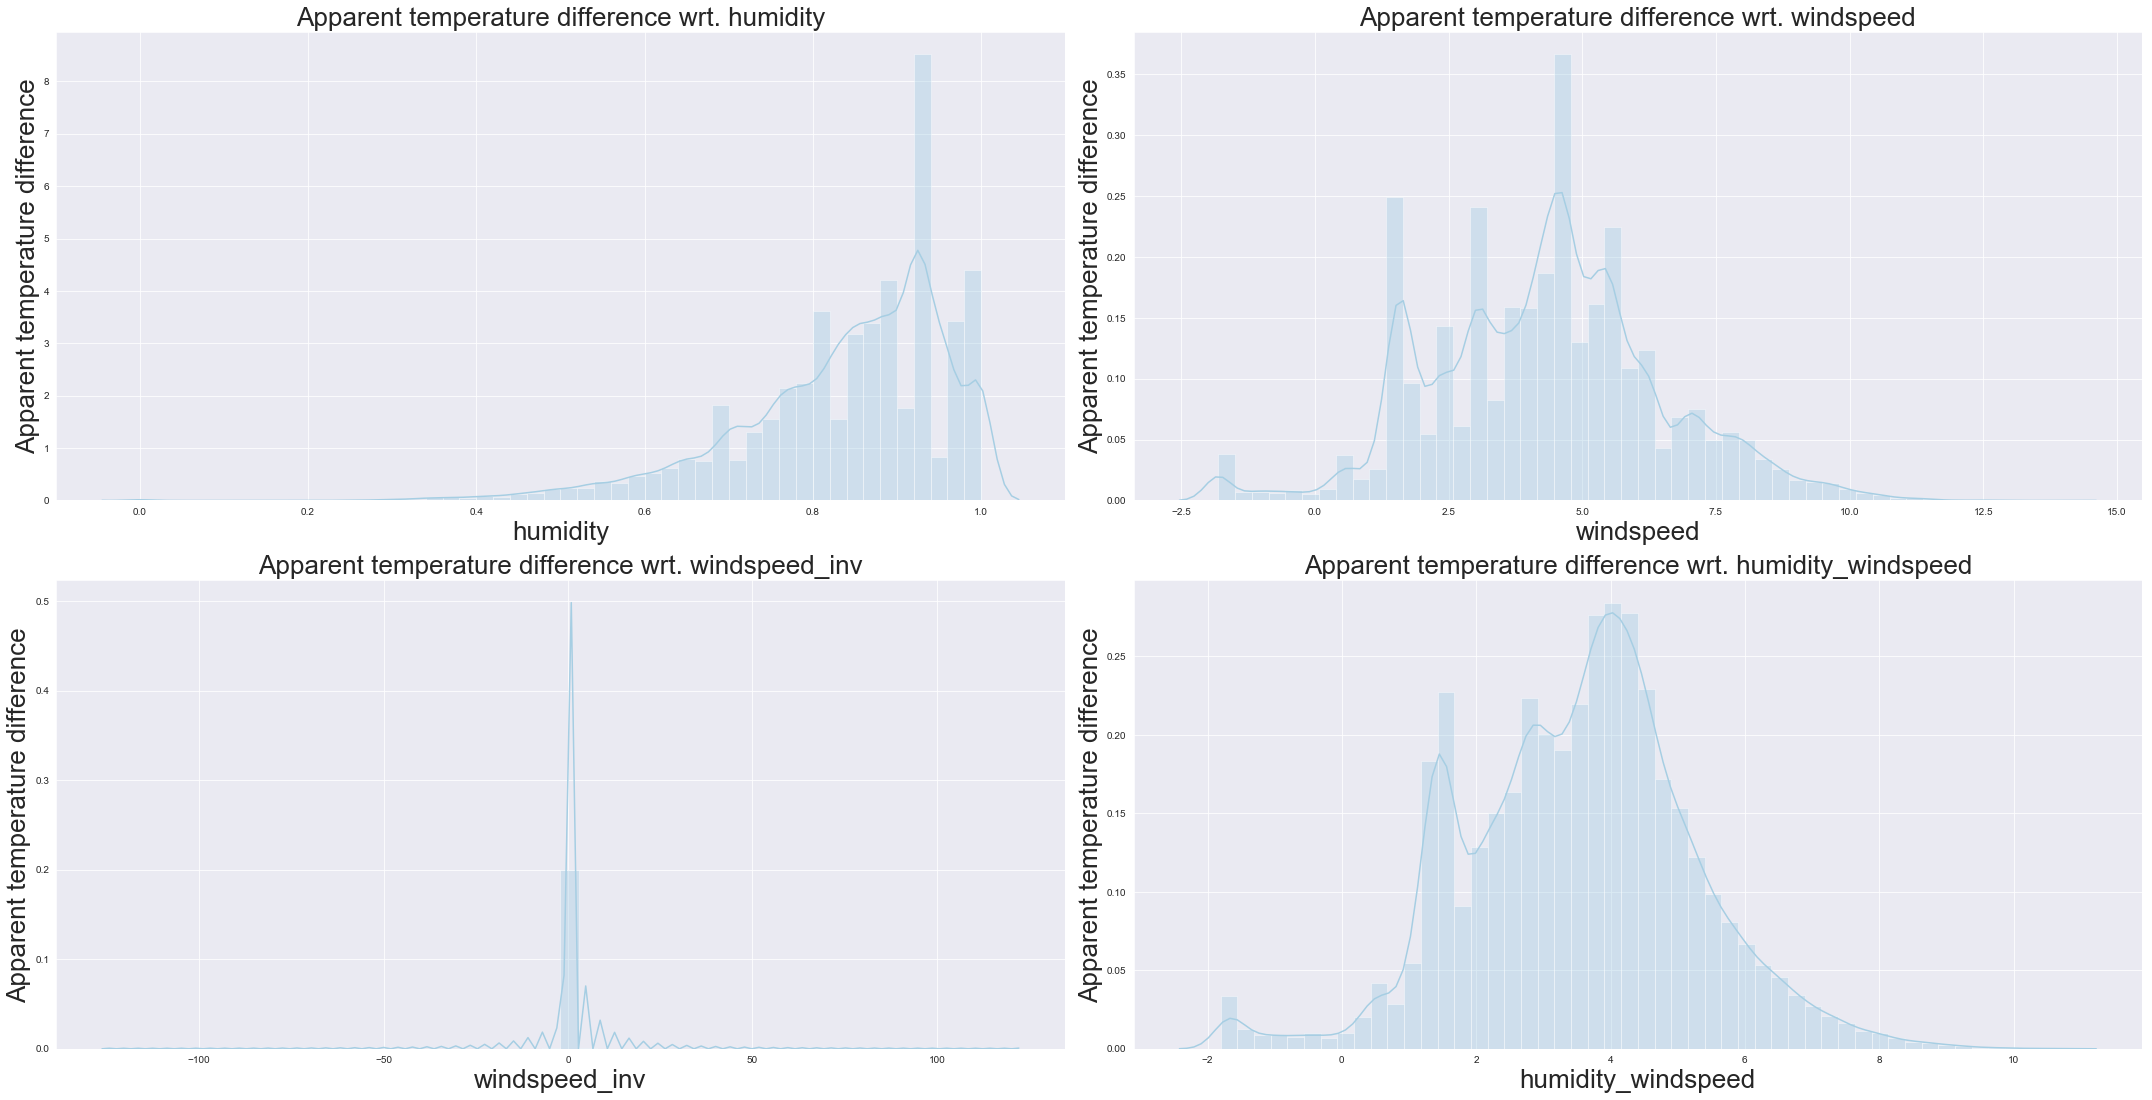

In [20]:
# visualize distributions in apparent cold temps
plt.figure(figsize=(30,30))

cols = weather_df2_cold.columns[:-1]
for index, col in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.distplot(weather_df2_cold[col])
    plt.title('Apparent temperature difference wrt. {}'.format(col), size=26)
    plt.ylabel('Apparent temperature difference', size=26)
    plt.xlabel(col, size=26)

plt.tight_layout()
plt.show()

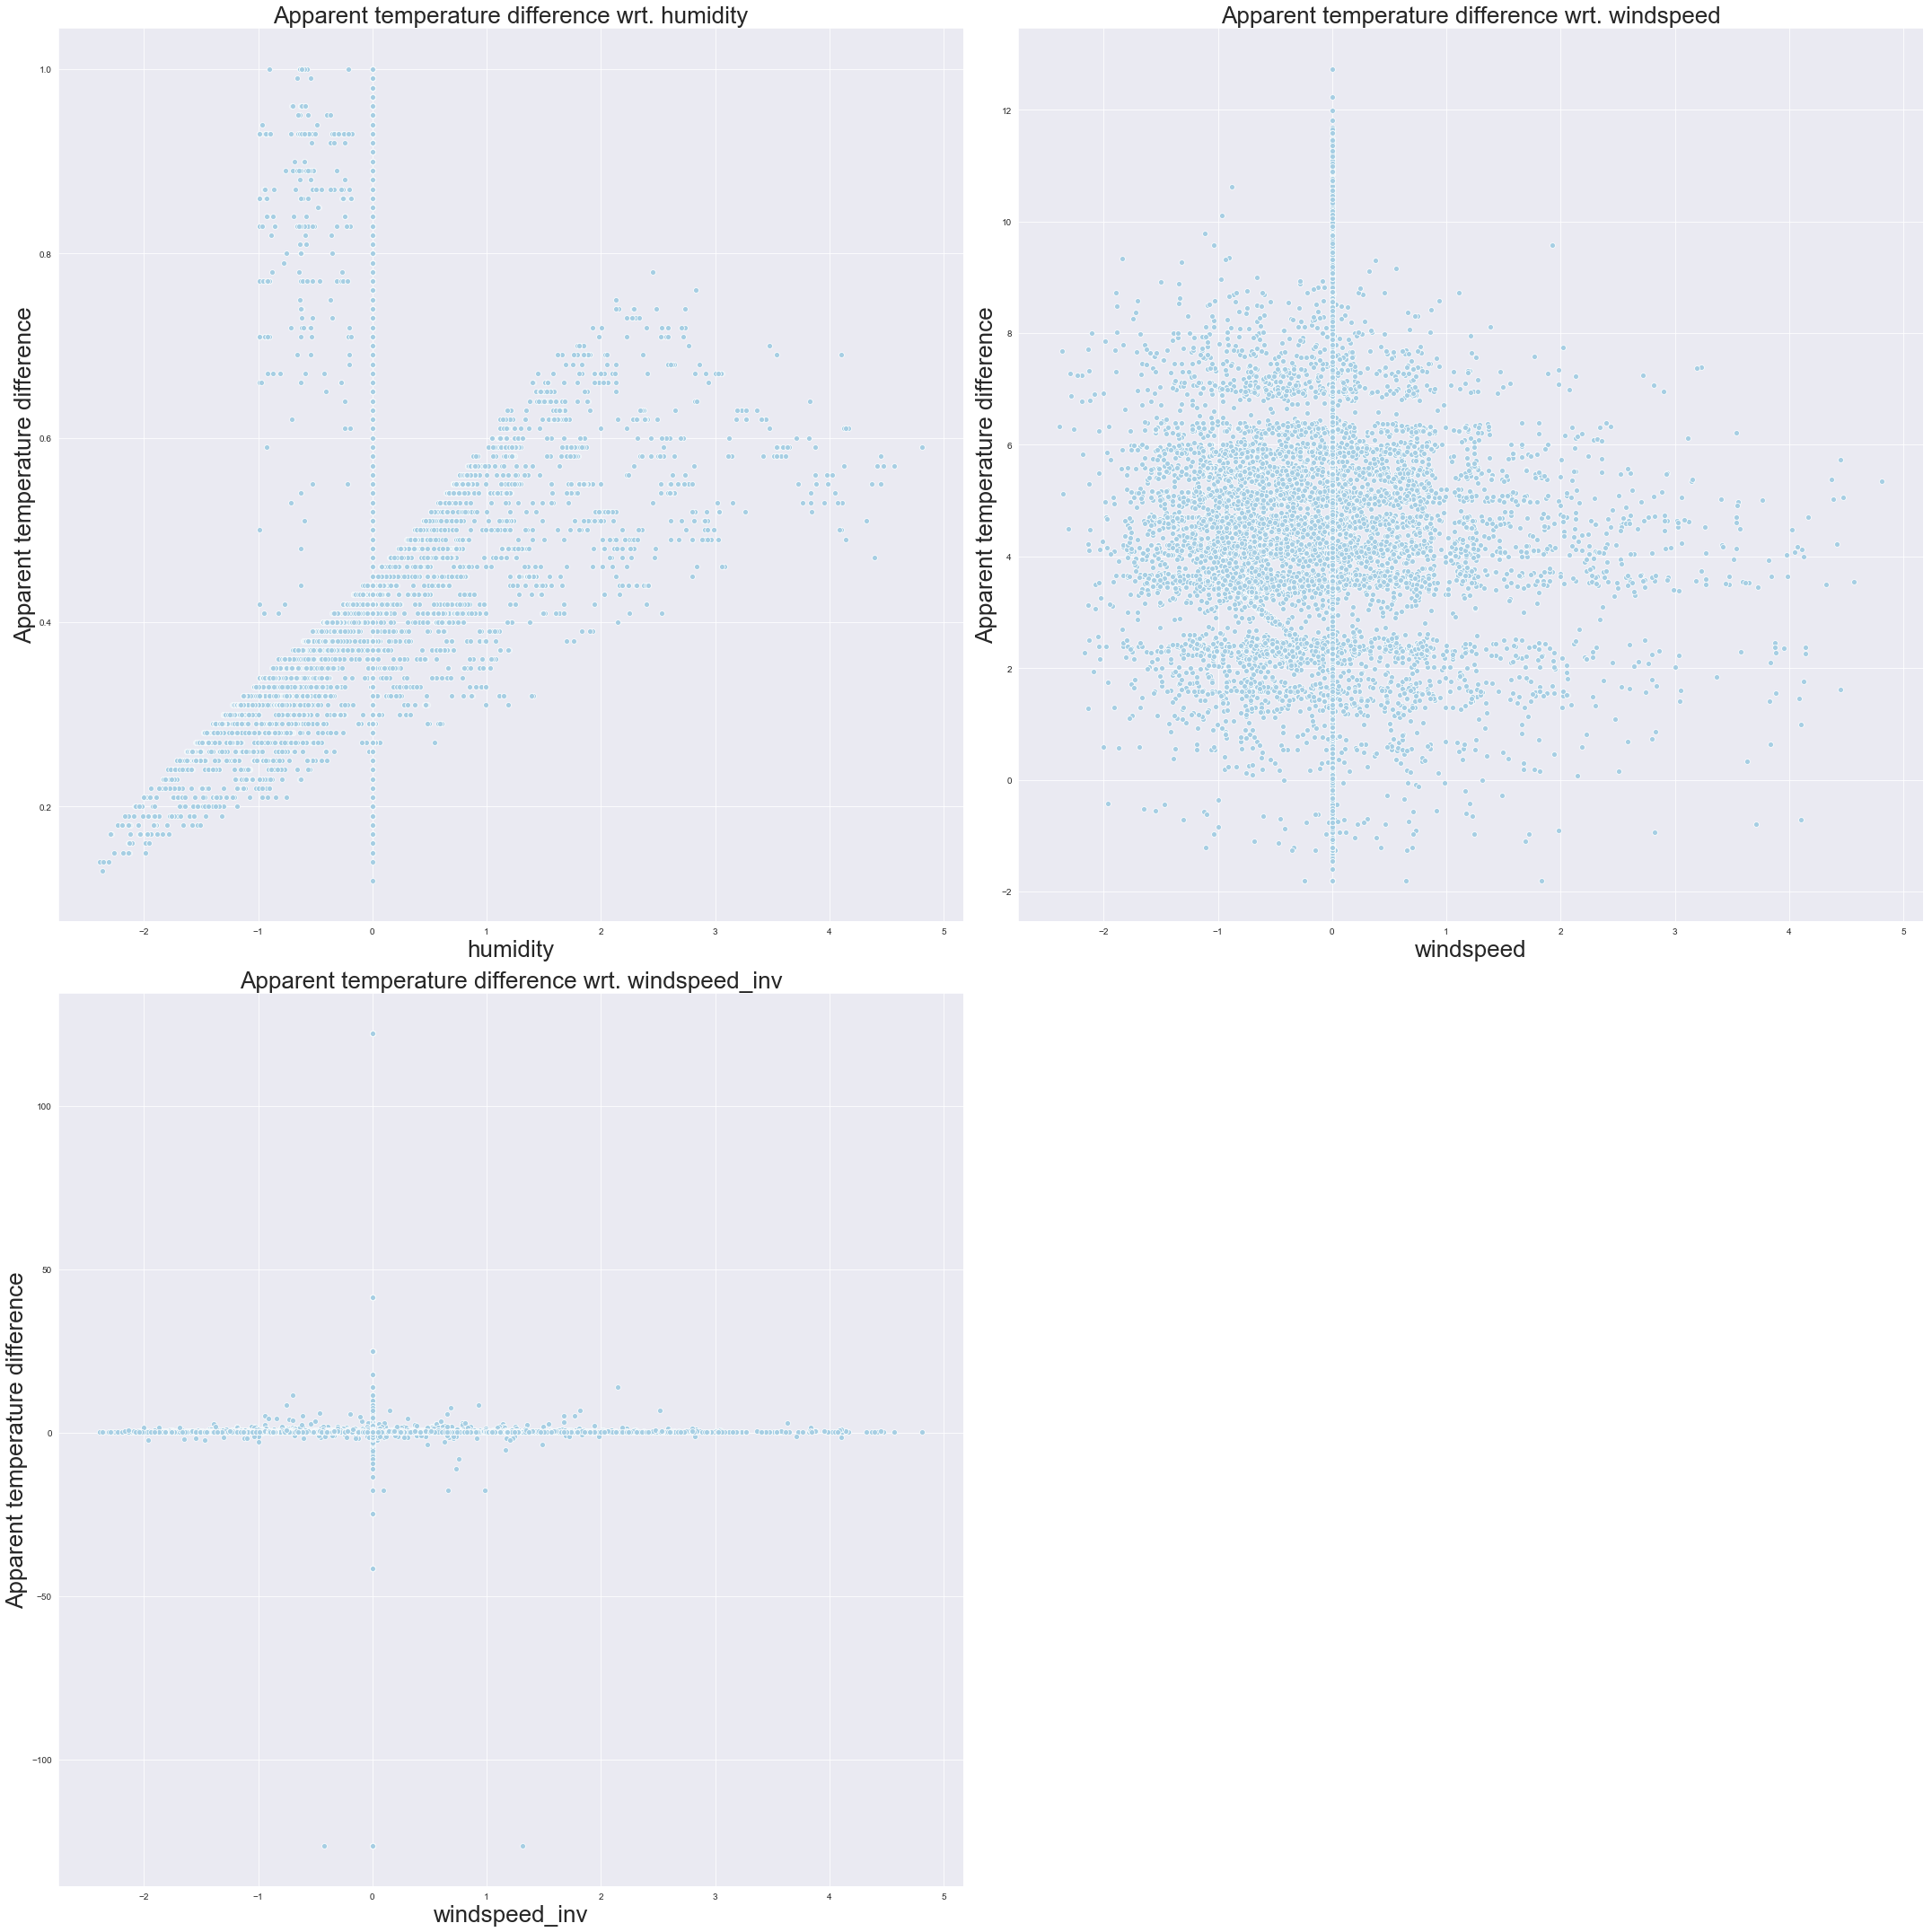

In [21]:
# visualize differences in apparent warm temps
plt.figure(figsize=(30,30))

cols = weather_df2_warm.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(2,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df2_warm)
    plt.title('Apparent temperature difference wrt. {}'.format(column), size=26)
    plt.ylabel('Apparent temperature difference', size=26)
    plt.xlabel(column, size=26)

plt.tight_layout()
plt.show()

In [22]:
# Split model
target = weather_df2_cold['apparentdifference']
data = weather_df2_cold[cols]

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     apparentdifference   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 3.307e+04
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:51:18   Log-Likelihood:                -56762.
No. Observations:               41951   AIC:                         1.135e+05
Df Residuals:                   41947   BIC:                         1.136e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1650      0.037     31.510      0.000       1.093       1.237
humidity         -0.8464      0.039    -21.862      0.000      -0.922      -0.771
windspeed        -0.6752      0.002   -303.513      0.000      -0.680      -0.671
windspeed_inv     0.0104      0.002      5.564      0.000       0.007       0.014
==============================================================================
Omnibus:                     3955.182   Durbin-Watson:                   0.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5393.357
Skew:                          -0.778   Prob(JB):                         0.00
Kurtosis:                       3.817   Cond. No.                         57.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""